## A Simple P-cycle model

We consider a simple model for the cycling of phosphorus with 3 state variables consisting of dissolved inorganic phosphorus ([PO$_4^{3-}$]), dissolved organic phosphorus, DOP, and particulate organic phosphorus, POP.   

The dissolved phases are transported by advection and diffusion whereas the particulate phase sinks rapidly down the water column without any appreciable transport by the circulation.

The governing equations are:
$$ \frac{\partial}{\partial t} DIP + \nabla \cdot \left[\mathbf{u}DIP+\mathbf{K}\cdot\nabla DIP \right] = -\Gamma(DIP) + \kappa_d DOP $$
$$ \frac{\partial}{\partial t} DOP + \nabla \cdot \left[\mathbf{u}DOP+\mathbf{K}\cdot \nabla DOP \right] = \sigma\Gamma(DIP)+\kappa_p POP -\kappa_d DOP$$
$$ \frac{\partial}{\partial t} POP + \partial_z \left[w_p POP\right] = (1-\sigma)\Gamma(DIP)-\kappa_p POP$$
$$ \frac{\partial}{\partial t} DO2 + \nabla \cdot \left[\mathbf{u}DO2 + \mathbf{K}\cdot\nabla DO2\right] = -r_{\mbox{o2:p}}\kappa_d DOP + \boldsymbol{\Lambda}(DO2-[O_2]_{\mbox{sat}})$$
where:
<ul>
    <li>$\mathbf{u}$ is the fluid velocity. </li>
    <li>$\mathbf{K}$ is the eddy diffusion tensor. </li>
    <li>$w_p$ is a depth dependent particle sinking speed.</li>
    <li>$\Gamma(DIP)$ is the biological uptake of DIP by phytoplankton. </li>
    <li>$\sigma$ is the fraction of the organic matter production allocated to the dissolved phase.</li>
    <li>$(1-\sigma$ is the fraction of the organic matter production allocated to the particulate phase.</li>
    <li>$\kappa_d$ is the respiration rate for dissolved organic matter.</li>
    <li>$\kappa_p$ is the dissolution rate for particulate organic matter.</li>
    <li>$\Lambda$ is the air-sea gas exchange operator</li>
    <li>$r_{\mbox{o2:p}}$ is the number of moles of O$_2$ needed to respire 1 mole of DOP</li>
</ul>

In [2]:
using AIBECS

# Load the circulation and grid
const wet3d, grd, T_Circulation = OCIM1.load()

# Define useful constants and arrays
const iwet = indices_of_wet_boxes(wet3d)
const nb = number_of_wet_boxes(wet3d)
const v = vector_of_volumes(wet3d, grd)
const z = vector_of_depths(wet3d, grd)
const ztop = vector_of_top_depths(wet3d, grd)
# And matrices
const DIV = buildDIV(wet3d, iwet, grd)
const Iabove = buildIabove(wet3d, iwet) ;


Loading OCIM1 with JLD2

┌ Warning: Over-writing registration of the datadep
│   name = MatricesForJAMES
└ @ DataDeps /Users/fprimeau/.julia/packages/DataDeps/LiEdA/src/registration.jl:8


 ✅


In [3]:
#===========================================
Transport matrices
===========================================#
T_DIP(p) = T_Circulation
T_DOP(p) = T_Circulation
T_DO2(p) = T_Circulation
const S₀ = buildPFD(ones(nb), DIV, Iabove)
const S′ = buildPFD(ztop, DIV, Iabove)
function T_POP(p)
    w₀, w′ = p.w₀, p.w′
    return w₀ * S₀ + w′ * S′
end
T_all = (T_DIP, T_DOP, T_POP, T_DO2)

(T_DIP, T_DOP, T_POP, T_DO2)

Because AIBECS will solve for the steady state solution directly without time-stepping the goverining equations to equilibrium, we don't have any opportunity to specify any intial conditions. Initial conditions are how the total amount of conserved elements get specified in most global biogeochemical modelels.  Thus to specify the total inventory of P in AIBECS we add a very weak resporing term to the DIP equation. The time-scale for this restoring term is chosen to be very long compared to the timescale with which the ocean circulation homogenizes a tracer. Because of this long timescale we call it the geological restoring term, but geochemists who work on geological processes don't like that name! In any event the long timescale allows us to prescribe the total inventory of P without having any appreciable impact on the 3d distribution of P.

In [4]:
#===========================================
Sources minus sinks
===========================================#
# Geological Restoring
function geores(x, p)
    τg, xgeo = p.τg, p.xgeo
    return (xgeo .- x) / τg
end

geores (generic function with 1 method)

In [5]:
# Uptake of phosphate (DIP)
relu(x) = (x .≥ 0) .* x
function uptake(DIP, p)
    τu, ku, z₀ = p.τu, p.ku, p.z₀
    DIP⁺ = relu(DIP)
    return 1/τu * DIP⁺.^2 ./ (DIP⁺ .+ ku) .* (z .≤ z₀)
end

uptake (generic function with 1 method)

In [6]:
# Remineralization DOP into DIP
function remineralization(DOP, p)
    κDOP = p.κDOP
    return κDOP * DOP
end

remineralization (generic function with 1 method)

In [9]:
# Dissolution of POP into DOP
function dissolution(POP, p)
    κPOP = p.κPOP
    return κPOP * POP
end

dissolution (generic function with 1 method)

In [11]:
# Simple air-sea gas exchange operator
dz1 = grd["dzt"][1]               # thickness of the top layer
z = vec(grd["ZT3d"])[iwet]        # depth of the gridbox centers
using WorldOceanAtlasTools
WOA = WorldOceanAtlasTools
μDO2 , σ²DO2 = WOA.fit_to_grid(grd,2018,"O2sat","annual","1°","an")
#function airsea(DO2, p)
#    κDO2 = p.κDO2
#    return κDO2 * (z .< 20) .* (1.0 .- DO2) / dz1
#end

Trying OPeNDAP first


  Reading NetCDF file
  Rearranging data
  Filtering data
  Averaging data over each grid box
  Setting μ = 0 and σ² = ∞ where no obs
  Setting a realistic minimum for σ²


KeyError: KeyError: key "percent" not found

In [10]:
# Add them up into sms functions (Sources Minus Sinks)
function sms_DIP(DIP, DOP, POP, p)
    return -uptake(DIP, p) + remineralization(DOP, p) + geores(DIP, p)
end
function sms_DOP(DIP, DOP, POP, p)
    σ = p.σ
    return σ * uptake(DIP, p) - remineralization(DOP, p) + dissolution(POP, p)
end
function sms_POP(DIP, DOP, POP, p)
    σ = p.σ
    return (1 - σ) * uptake(DIP, p) - dissolution(POP, p)
end
sms_all = (sms_DIP, sms_DOP, sms_POP) # bundles all the source-sink functions in a tuple

(sms_DIP, sms_DOP, sms_POP)

In [12]:
# Build the parameters type and p₀
t = empty_parameter_table()    # initialize table of parameters
add_parameter!(t, :xgeo, 2.17u"mmol/m^3",
    variance_obs = ustrip(upreferred(0.1 * 2.17u"mmol/m^3"))^2,
    description = "Geological mean P concentration",
    LaTeX = "\\state^\\mathrm{geo}")
add_parameter!(t, :τg, 1.0u"Myr",
    description = "Geological restoring timescale",
    LaTeX = "\\tau_\\mathrm{geo}")
add_parameter!(t, :ku, 10.0u"μmol/m^3",
    optimizable = true,
    description = "Half-saturation constant (Michaelis-Menten)",
    LaTeX = "k_\\vec{u}")
add_parameter!(t, :z₀, 80.0u"m",
    description = "Depth of the euphotic layer base",
    LaTeX = "z_0")
add_parameter!(t, :w₀, 1.0u"m/d",
    optimizable = true,
    description = "Sinking velocity at surface",
    LaTeX = "w_0")
add_parameter!(t, :w′, 1/4.4625u"d",
    optimizable = true,
    description = "Vertical gradient of sinking velocity",
    LaTeX = "w'")
add_parameter!(t, :κDOP, 1/0.25u"yr",
    optimizable = true,
    description = "Remineralization rate constant (DOP to DIP)",
    LaTeX = "\\kappa")
add_parameter!(t, :κPOP, 1/5.25u"d",
    optimizable = true,
    description = "Dissolution rate constant (POP to DOP)",
    LaTeX = "\\kappa")
add_parameter!(t, :σ, 0.3u"1",
    description = "Fraction of quick local uptake recycling",
    LaTeX = "\\sigma")
add_parameter!(t, :τu, 30.0u"d",
    optimizable = true,
    description = "Maximum uptake rate timescale",
    LaTeX = "\\tau_\\vec{u}")
initialize_Parameters_type(t)   # Generate the parameter type

In [19]:
#===========================================
AIBECS F and ∇ₓF
===========================================#
F, ∇ₓF = state_function_and_Jacobian(T_all, sms_all, nb)
nt = length(T_all)    # number of tracers
n = nt * nb           # total dimension of the state vector
x₀ = p₀.xgeo * ones(n) # initial iterate
F₀ = F(x₀, p₀)
∇ₓF₀ = ∇ₓF(x₀, p₀) ;
prob = SteadyStateProblem(F, ∇ₓF, x₀, p₀)
s = solve(prob, CTKAlg());

In [46]:
function unpack_P_state(s,mask)
        DIP = NaN*mask; DOP = NaN*mask; POP = NaN*mask
        iwet = findall(x-> x==1, vec(mask))
        nwet = length(iwet)
        idip = 1:nwet;       idop = idip.+nwet;   ipop = idop.+nwet
        DIP[iwet] = s[idip]; DOP[iwet] = s[idop]; POP[iwet] = s[ipop]
    return DIP, DOP, POP
end

unpack_P_state (generic function with 1 method)

In [47]:
DIP, DOP, POP = unpack_P_state(s,wet3d);

We will plot the concentration of DIP at a given depth horizon

In [53]:
depth = vec(grd["zt"])
iz = findfirst(depth .> 200)
iz, depth[iz]

(6, 246.7350746268657)

In [54]:
dip = DIP[:,:,iz] * ustrip(1.0u"mol/m^3"|>u"mmol/m^3");
lat, lon = vec(grd["yt"]), vec(grd["xt"]);

┌ Info: Running `conda install -y Cartopy` in root environment
└ @ Conda /Users/fprimeau/.julia/packages/Conda/CpuvI/src/Conda.jl:112


Solving environment: ...working... done

# All requested packages already installed.



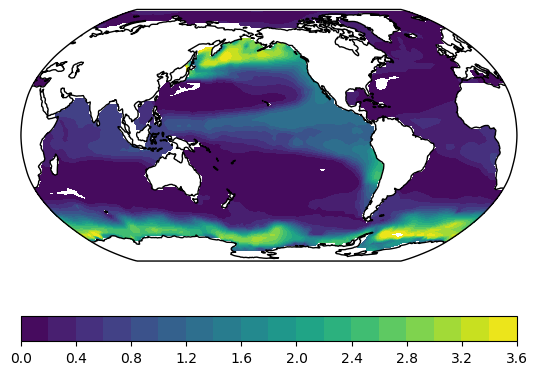

In [59]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall
using Conda; Conda.add("Cartopy")
ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.Robinson(central_longitude=-155.0))
ax.coastlines()
# making it cyclic for Cartopy
lon_cyc = [lon; 360+lon[1]] 
dip_cyc = hcat(dip, dip[:,1])
# And plot
p = contourf(lon_cyc, lat, dip_cyc, levels=0:0.2:3.6, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal");

In [26]:
size(DIP)

(200160,)